# EXPLORATION 20. 어라, 이 시계열 데이터 이상한데? - Anomaly Detection

## Import

In [1]:
import os
import copy
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

from statsmodels.stats.weightstats import ztest
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Dataset

In [2]:
csv_file = 'data/nasdaq.csv'

df = pd.read_csv(csv_file)
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,2375.000000,2414.0,2130.500000,2167.5,2167.5,87316.0
1,2001-01-03,2201.840088,2590.0,2201.840088,2529.5,2529.5,115138.0


In [3]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1054
High         1054
Low          1054
Close        1054
Adj Close    1054
Volume       1054
dtype: int64

In [4]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6075
삭제 후 데이터 길이(일자수): 5021


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

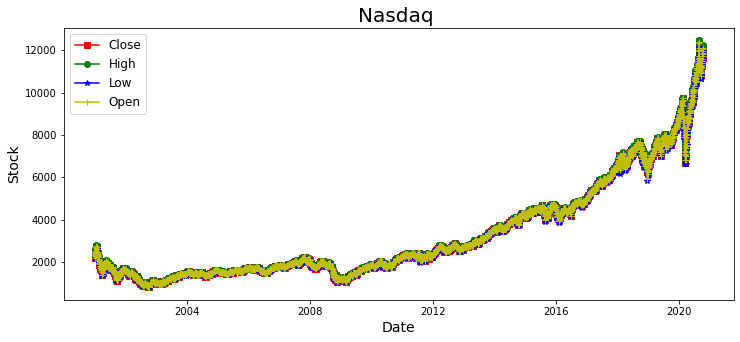

In [5]:
plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('Nasdaq ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

## Outlier

### Preprocess

In [6]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

In [7]:
# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])

In [8]:
tdf.describe()

,Open,High,Low,Close,Volume
count,5021.000000,5021.000000,5021.000000,5021.000000,5021.000000
mean,3327.715882,3358.210568,3296.544557,3329.819833,290933.377612
std,2407.789821,2429.663192,2386.531208,2411.671304,107141.900139
min,914.415000,934.695000,895.770000,915.335000,61991.473982
25%,1580.955000,1594.040000,1568.950000,1580.710000,222429.470000
50%,2225.270000,2254.790000,2194.430000,2226.028301,270032.110000
75%,4441.017500,4474.492500,4407.215000,4442.005000,320986.130000
max,12064.786259,12214.296509,11897.172140,12066.724264,776809.340000


In [9]:
sdf.describe()

,Open,High,Low,Close,Volume
count,5021.000000,5021.000000,5021.000000,5021.000000,5021.000000
mean,-0.010005,-0.010186,-0.005284,-0.005787,-12.007183
std,11.310500,10.492406,11.917070,11.219058,14696.168957
min,-24.860154,-25.201291,-28.337268,-23.907199,-36296.725059
25%,-7.293117,-4.409314,-7.995852,-6.488880,-11605.821707
50%,1.579461,1.721451,1.838739,2.281912,-1417.298215
75%,6.807741,6.358528,8.651397,7.080458,10296.106879
max,21.990131,17.452191,18.637711,20.525944,35004.051685


In [10]:
rdf.describe()

,Open,High,Low,Close,Volume
count,5021.000000,5021.000000,5021.000000,5021.000000,5021.000000
mean,-1.443281,-1.250221,-1.371191,-1.280076,253.666615
std,112.609961,102.260362,116.804113,110.233811,111484.056248
min,-1278.358558,-1492.272748,-1224.120340,-1387.270119,-602522.937800
25%,-37.123452,-34.453979,-37.617811,-36.703388,-54426.246385
50%,3.474747,3.505105,4.577095,3.113005,-576.813338
75%,39.737757,37.155522,41.119160,40.375080,52253.558504
max,997.352857,936.263024,939.394089,996.696068,810544.257715


In [11]:
# 표준정규화
scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.44328135  -1.25022067  -1.37119077  -1.28007594 253.66661508]


array([[-1.3895458 , -1.62074432, -2.70672335, -3.04068104,  0.43339307],
       [-2.84160267,  0.18826095, -2.00808957,  0.38176015,  0.58302275],
       [ 0.18081107,  0.1744887 ,  0.31423535,  0.05330693,  0.31986727],
       ...,
       [-0.67734297, -1.83898628, -0.97851353, -1.33261068,  0.28071988],
       [-1.31743605, -1.6298619 , -0.69105502, -2.18102949, -0.36392786],
       [-2.12480212, -2.49646933, -2.58180458, -3.73108478, -0.27650503]])

### Confidence interval

#### Open

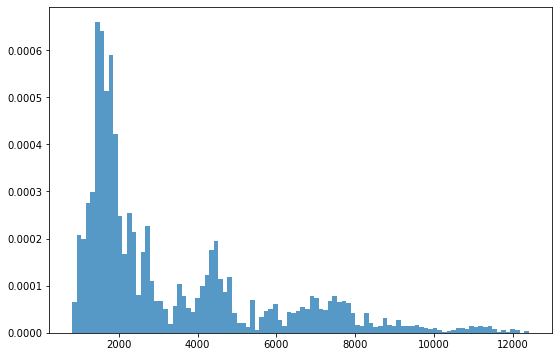

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Open, 100, density=True, alpha=0.75)

In [13]:
# normal distribution과 얼마나 가까운지 확인
# p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다고 판단
_, p = ztest(df.Open)
print(p)

0.0


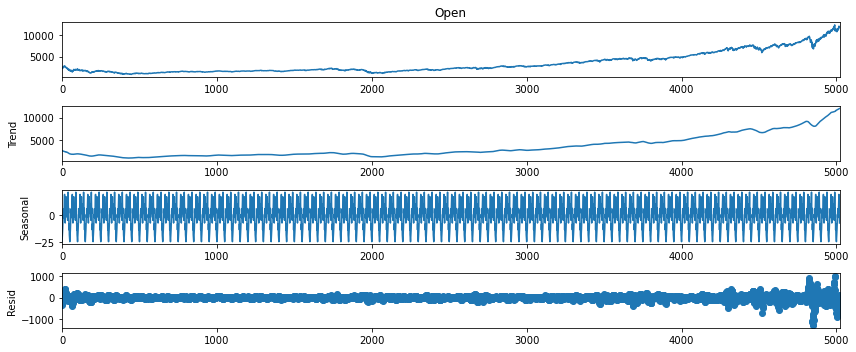

In [14]:
result_open = seasonal_decompose(df.Open, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result_open.plot()
plt.show()

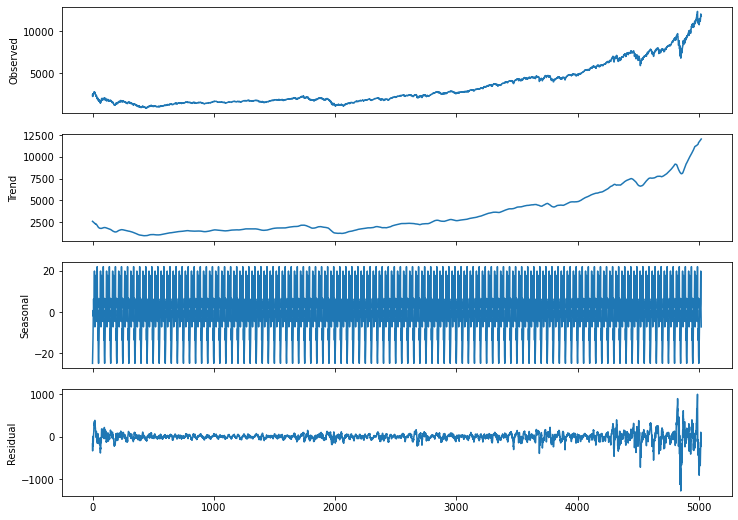

In [15]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result_open.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_open.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_open.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_open.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

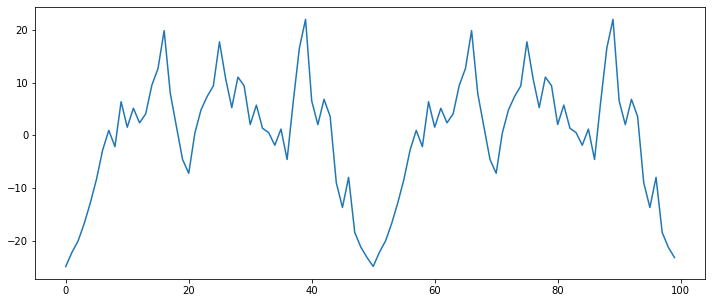

In [16]:
result_open.seasonal[:100].plot()

In [17]:
r = result_open.resid.values
st, p = ztest(r)
print(st,p)

-0.9114861576743556 0.36203927580072337


In [18]:
# 평균과 표준편차 출력
mu, std = result_open.resid.mean(), result_open.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result_open.resid[(result_open.resid>mu+3*std)|(result_open.resid<mu-3*std)]))

평균: -1.4460891305035328 표준편차: 112.41909759995713
이상치 갯수: 92


#### High

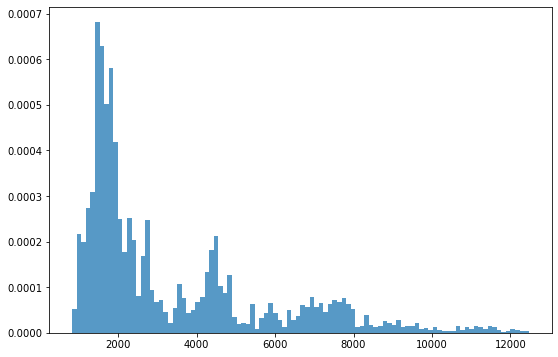

In [19]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.High, 100, density=True, alpha=0.75)

In [20]:
# normal distribution과 얼마나 가까운지 확인
# p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다고 판단
_, p = ztest(df.High)
print(p)

0.0


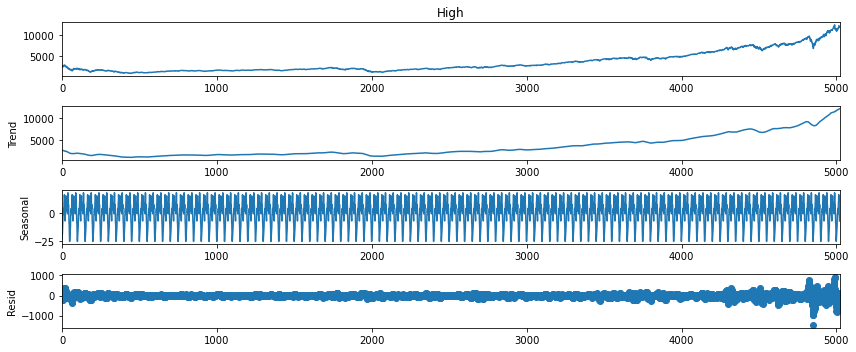

In [21]:
result_high = seasonal_decompose(df.High, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result_high.plot()
plt.show()

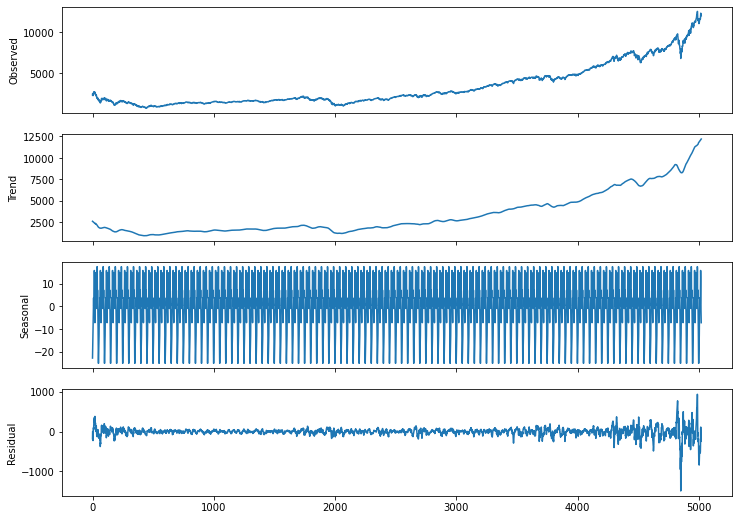

In [22]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result_high.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_high.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_high.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_high.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

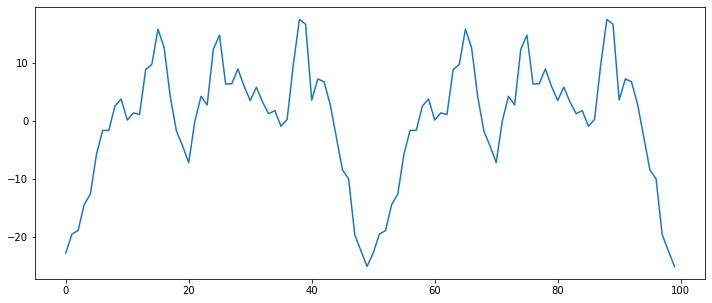

In [23]:
result_high.seasonal[:100].plot()

In [24]:
r = result_high.resid.values
st, p = ztest(r)
print(st,p)

-0.8731796624920525 0.38256515821495707


In [25]:
# 평균과 표준편차 출력
mu, std = result_high.resid.mean(), result_high.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result_high.resid[(result_high.resid>mu+3*std)|(result_high.resid<mu-3*std)]))

평균: -1.2576096818306908 표준편차: 102.05572469997603
이상치 갯수: 99


#### Low

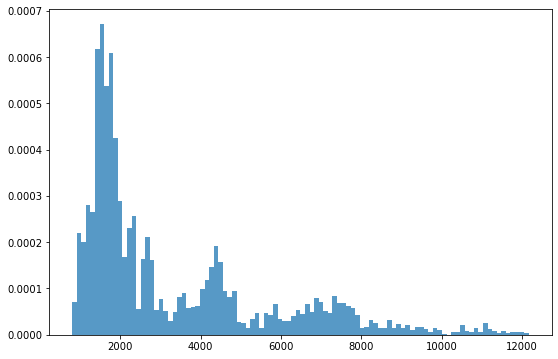

In [26]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Low, 100, density=True, alpha=0.75)

In [27]:
# normal distribution과 얼마나 가까운지 확인
# p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다고 판단
_, p = ztest(df.Low)
print(p)

0.0


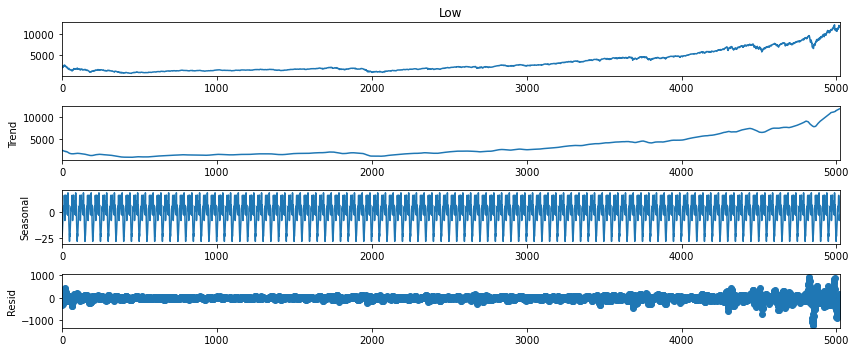

In [28]:
result_low = seasonal_decompose(df.Low, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result_low.plot()
plt.show()

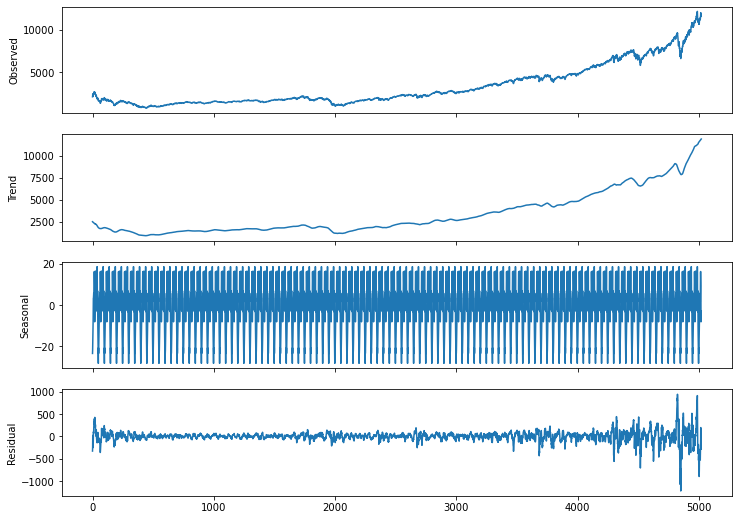

In [29]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result_low.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_low.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_low.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_low.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

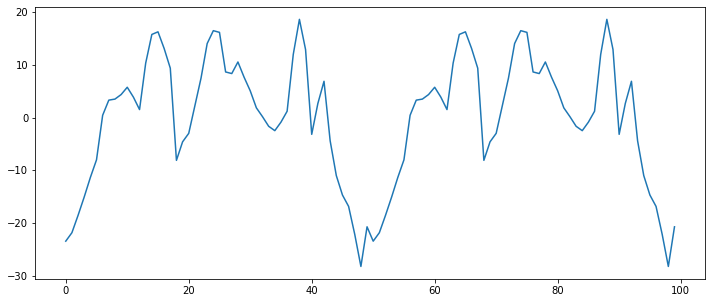

In [30]:
result_low.seasonal[:100].plot()

In [31]:
r = result_low.resid.values
st, p = ztest(r)
print(st,p)

-0.8338685651393092 0.40435505282741857


In [32]:
# 평균과 표준편차 출력
mu, std = result_low.resid.mean(), result_low.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result_low.resid[(result_low.resid>mu+3*std)|(result_low.resid<mu-3*std)]))

평균: -1.3723581525540458 표준편차: 116.61783513255786
이상치 갯수: 95


#### Close

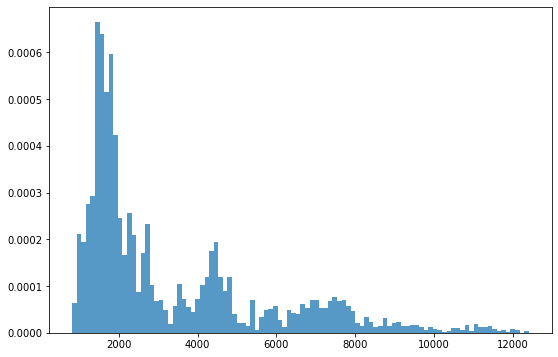

In [33]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [34]:
# normal distribution과 얼마나 가까운지 확인
# p가 0.05 이하로 나왔으면 normal distribution과 거리가 멀다고 판단
_, p = ztest(df.Close)
print(p)

0.0


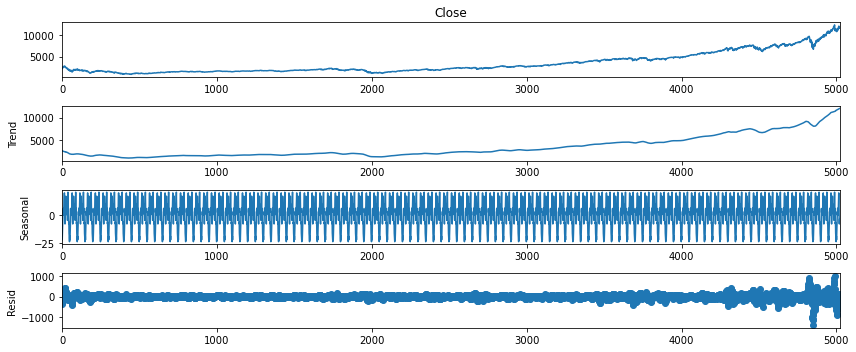

In [35]:
result_close = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result_close.plot()
plt.show()

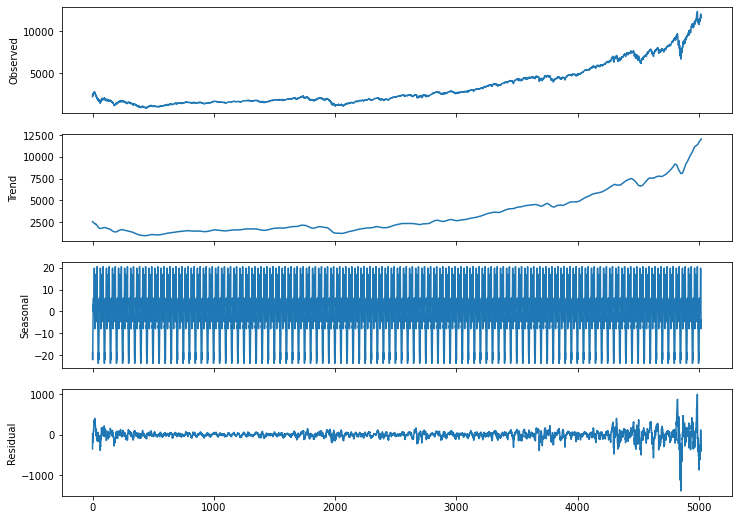

In [36]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result_close.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result_close.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result_close.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result_close.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

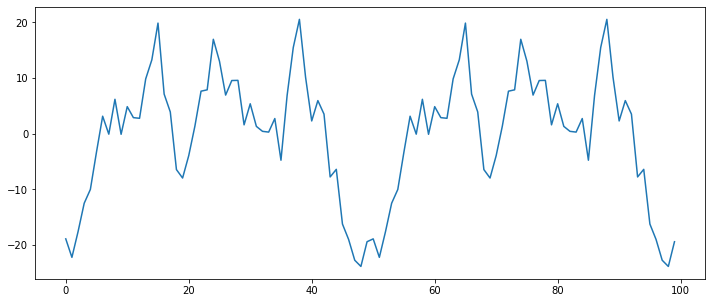

In [37]:
result_close.seasonal[:100].plot()

In [38]:
r = result_close.resid.values
st, p = ztest(r)
print(st,p)

-0.8287428902993691 0.4072499103509495


In [39]:
# 평균과 표준편차 출력
mu, std = result_close.resid.mean(), result_close.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result_close.resid[(result_close.resid>mu+3*std)|(result_close.resid<mu-3*std)]))

평균: -1.2869418191501398 표준편차: 110.03585149655403
이상치 갯수: 96


### k-means

In [40]:
kmeans = KMeans(n_clusters=26, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:360',
 'group:1-count:579',
 'group:2-count:78',
 'group:3-count:6',
 'group:4-count:114',
 'group:5-count:658',
 'group:6-count:10',
 'group:7-count:12',
 'group:8-count:107',
 'group:9-count:127',
 'group:10-count:20',
 'group:11-count:17',
 'group:12-count:684',
 'group:13-count:356',
 'group:14-count:294',
 'group:15-count:45',
 'group:16-count:199',
 'group:17-count:145',
 'group:18-count:59',
 'group:19-count:476',
 'group:20-count:92',
 'group:21-count:2',
 'group:22-count:257',
 'group:23-count:286',
 'group:24-count:8',
 'group:25-count:30']

In [41]:
df[(kmeans.labels_ == 3) | (kmeans.labels_ == 6) | (kmeans.labels_ == 7)
    | (kmeans.labels_ == 21) | (kmeans.labels_ == 24)]

,Date,Open,High,Low,Close,Adj Close,Volume
4301,2018-02-09,6328.000000,6455.500000,6164.000000,6417.750000,6417.750000,787495.0
4523,2019-01-03,6242.750000,6304.250000,6148.500000,6162.000000,6162.000000,714536.0
4626,2019-06-03,7110.000000,7132.500000,6941.250000,6993.750000,6993.750000,771723.0
4818,2020-02-11,9525.000000,9609.500000,9501.250000,9527.250000,9527.250000,589570.0
4819,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4820,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4821,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4822,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4823,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0
4824,2020-02-19,9643.250000,9748.750000,9641.250000,9733.500000,9733.500000,419130.0


In [42]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5021.000000,5021.000000,5021.000000,5021.000000,5021.000000,5.021000e+03
mean,3326.262595,3356.950161,3295.168082,3328.533969,3328.533969,2.911750e+05
std,2407.109123,2428.512631,2386.467629,2410.949334,2410.949334,1.582379e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1586.000000,1603.000000,1572.000000,1586.250000,1586.250000,1.944700e+05
50%,2211.500000,2228.000000,2187.000000,2212.000000,2212.000000,2.678040e+05
75%,4470.000000,4494.000000,4432.500000,4467.750000,4467.750000,3.571590e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


In [43]:
# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

,Open,High,Low,Close,Volume
0,-0.362197,-0.379321,-0.422064,-0.406632,0.772851
1,0.086225,0.070674,0.149818,0.122612,-0.536736
2,2.536931,2.657884,2.648400,2.624447,-0.378607
3,-4.166990,-4.968911,-4.243904,-4.777299,3.066878
4,-0.200523,-0.270948,-0.621190,-0.596316,2.206698
5,0.322313,0.349975,0.325231,0.327775,0.087170
6,-8.296784,-6.975800,-7.900279,-6.431213,-1.509180
7,5.431887,5.553013,6.092909,5.979620,-1.553635
8,-1.194406,-1.211582,-1.361009,-1.299593,1.280282
9,-0.625873,-0.701919,-0.505326,-0.561752,-1.410151


#### Open

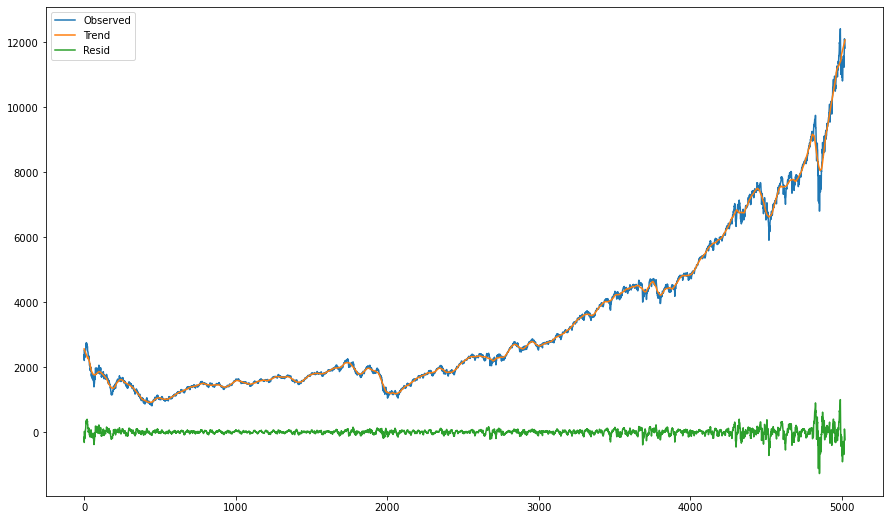

In [44]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Open.plot(ax=ax, label='Observed', legend=True)
tdf.Open.plot(ax=ax, label='Trend', legend=True)
rdf.Open.plot(ax=ax,label='Resid', legend=True)
plt.show()

#### High

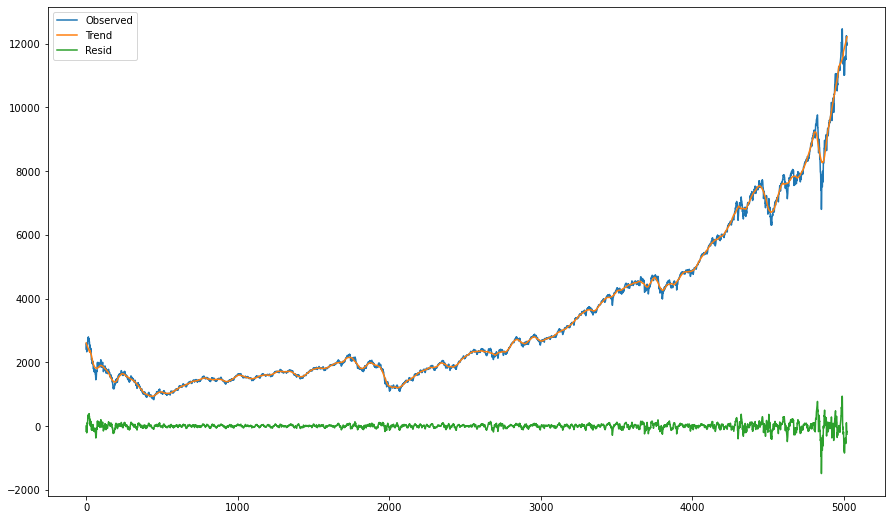

In [45]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.High.plot(ax=ax, label='Observed', legend=True)
tdf.High.plot(ax=ax, label='Trend', legend=True)
rdf.High.plot(ax=ax,label='Resid', legend=True)
plt.show()

#### Low

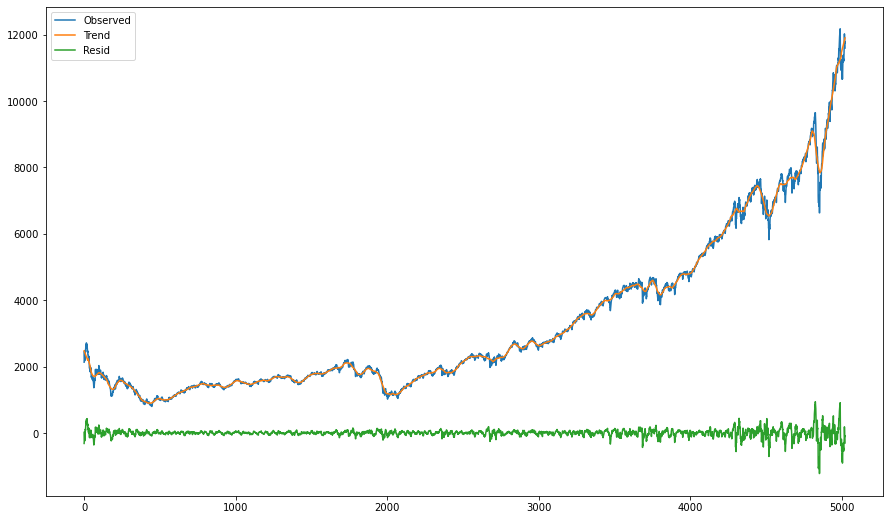

In [46]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Low.plot(ax=ax, label='Observed', legend=True)
tdf.Low.plot(ax=ax, label='Trend', legend=True)
rdf.Low.plot(ax=ax,label='Resid', legend=True)
plt.show()

#### Close

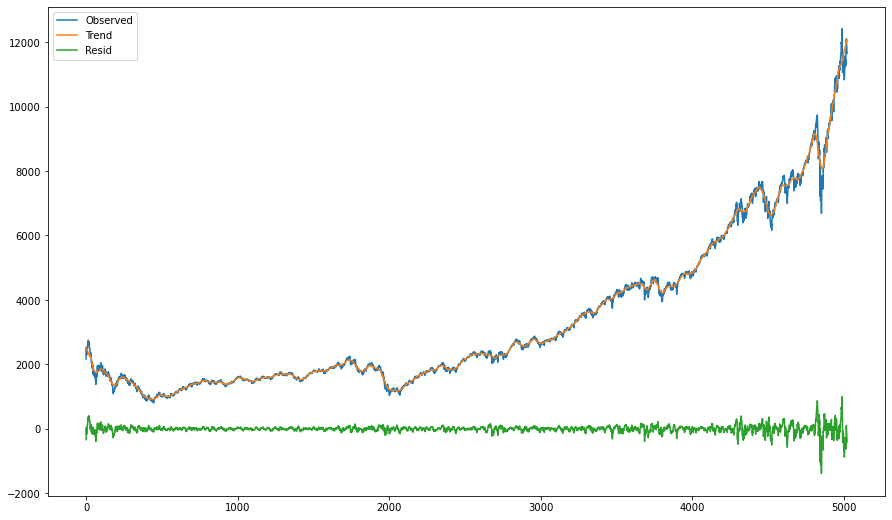

In [47]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

### DBSCAN

In [48]:
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [49]:
print(clustering.labels_)

[-1 -1  0 ...  0 -1 -1]


In [50]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:194',
 'group:0-count:4767',
 'group:1-count:2',
 'group:2-count:3',
 'group:3-count:2',
 'group:4-count:4',
 'group:5-count:3',
 'group:6-count:2',
 'group:7-count:2',
 'group:8-count:4',
 'group:9-count:5',
 'group:10-count:3',
 'group:11-count:2',
 'group:12-count:2',
 'group:13-count:3',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:2',
 'group:17-count:2',
 'group:18-count:2',
 'group:19-count:2',
 'group:20-count:2',
 'group:21-count:2',
 'group:22-count:3',
 'group:23-count:2',
 'group:24-count:2']

### Auto encoder

In [51]:
tf.random.set_seed(777)
np.random.seed(777)

In [52]:
window_size = 10
batch_size = 32
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [53]:
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 10, 5)
(32, 5)


In [54]:
model = Sequential([
    # encoder
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    
    ## Bottleneck
    RepeatVector(window_size),
    ## Bottleneck
    
    ## decoder
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
____________________________________________________

In [55]:
checkpoint_path = 'model/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [56]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50, 
          callbacks=[checkpoint, early_stop])

Epoch 1/50
157/157 [==============================] - ETA: 0s - loss: 1.4030 - mae: 1.4030
Epoch 00001: val_loss improved from inf to 0.60798, saving model to model/mymodel.ckpt
157/157 [==============================] - 5s 33ms/step - loss: 1.4030 - mae: 1.4030 - val_loss: 0.6080 - val_mae: 0.6080
Epoch 2/50
157/157 [==============================] - ETA: 0s - loss: 0.4633 - mae: 0.4633
Epoch 00002: val_loss did not improve from 0.60798
157/157 [==============================] - 5s 29ms/step - loss: 0.4633 - mae: 0.4633 - val_loss: 1.5376 - val_mae: 1.5376
Epoch 3/50
157/157 [==============================] - ETA: 0s - loss: 0.5532 - mae: 0.5532
Epoch 00003: val_loss did not improve from 0.60798
157/157 [==============================] - 5s 30ms/step - loss: 0.5532 - mae: 0.5532 - val_loss: 0.8574 - val_mae: 0.8574
Epoch 4/50
156/157 [============================>.] - ETA: 0s - loss: 0.3995 - mae: 0.3995
Epoch 00004: val_loss improved from 0.60798 to 0.46662, saving model to model/mym

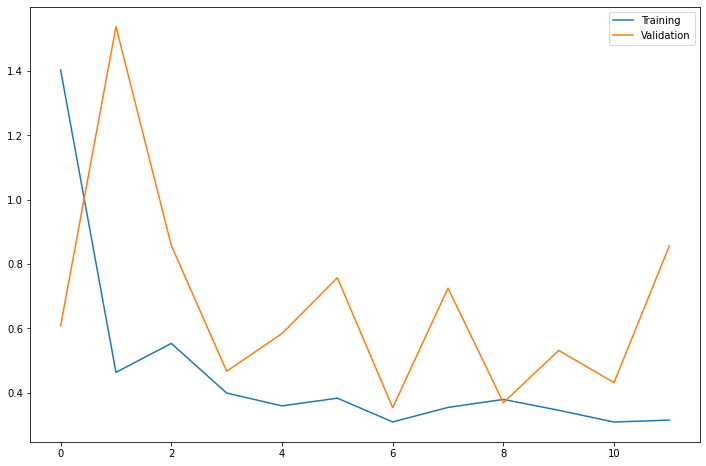

In [57]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

In [58]:
model.load_weights(checkpoint_path)

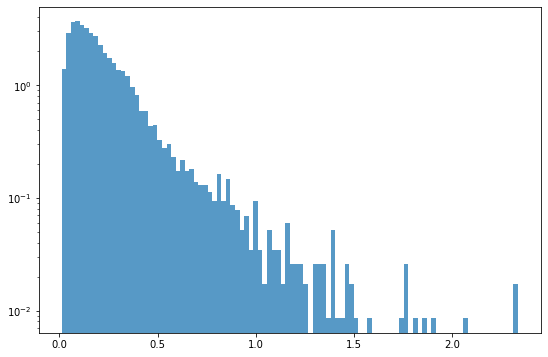

In [59]:
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [70]:
test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1.7
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
4459,2018-10-11,7010.25,7138.00,6907.75,7031.00,7031.00,1146270.0,1.860917
4819,2020-02-25,9091.00,9224.25,8810.00,8854.25,8854.25,1344897.0,1.901647
4820,2020-02-26,8868.25,9037.50,8709.50,8850.25,8850.25,1251412.0,1.738357
4821,2020-02-27,8811.50,8878.50,8334.25,8382.75,8382.75,1580041.0,2.324847
4822,2020-02-28,8347.00,8574.75,8126.25,8454.00,8454.00,1527204.0,2.334125
4823,2020-03-01,8347.00,8574.75,8126.25,8382.75,8382.75,1513887.0,2.072429
4824,2020-03-02,8349.25,8883.25,8224.25,8791.25,8791.25,1373357.0,1.811383
4825,2020-03-03,8830.50,9002.50,8511.00,8582.50,8582.50,1295648.0,1.773855
4833,2020-03-12,7998.75,8108.00,7128.50,7215.25,7215.25,876291.0,1.754601
4847,2020-03-29,7395.75,7507.25,7367.25,7489.25,7489.25,1256384.0,1.754399


/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


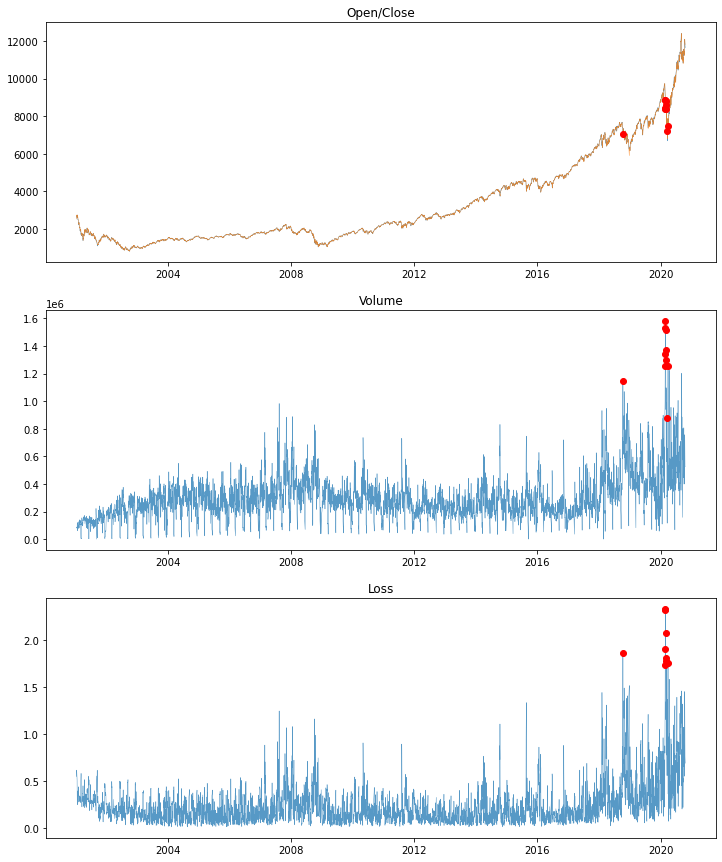

In [71]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

In [68]:
threshold = 1.1
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1674,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.246712
1962,2008-10-10,1281.750000,1326.250000,1198.250000,1282.500000,1282.500000,829115.0,1.161909
3461,2014-10-15,3823.750000,3831.500000,3691.250000,3752.000000,3752.000000,831107.0,1.107884
3674,2015-08-24,4183.750000,4196.250000,3908.250000,4003.250000,4003.250000,746533.0,1.335853
4287,2018-02-05,6752.250000,6813.500000,6387.750000,6429.250000,6429.250000,931677.0,1.443668
4288,2018-02-06,6473.000000,6677.500000,6260.250000,6653.750000,6653.750000,813419.0,1.323273
4291,2018-02-09,6328.000000,6455.500000,6164.000000,6417.750000,6417.750000,787495.0,1.173806
4323,2018-03-28,6550.250000,6582.250000,6421.000000,6477.250000,6477.250000,948120.0,1.310161
4458,2018-10-10,7394.750000,7412.000000,7000.000000,7032.000000,7032.000000,924204.0,1.215935
4459,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.860917


/home/aiffel0046/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


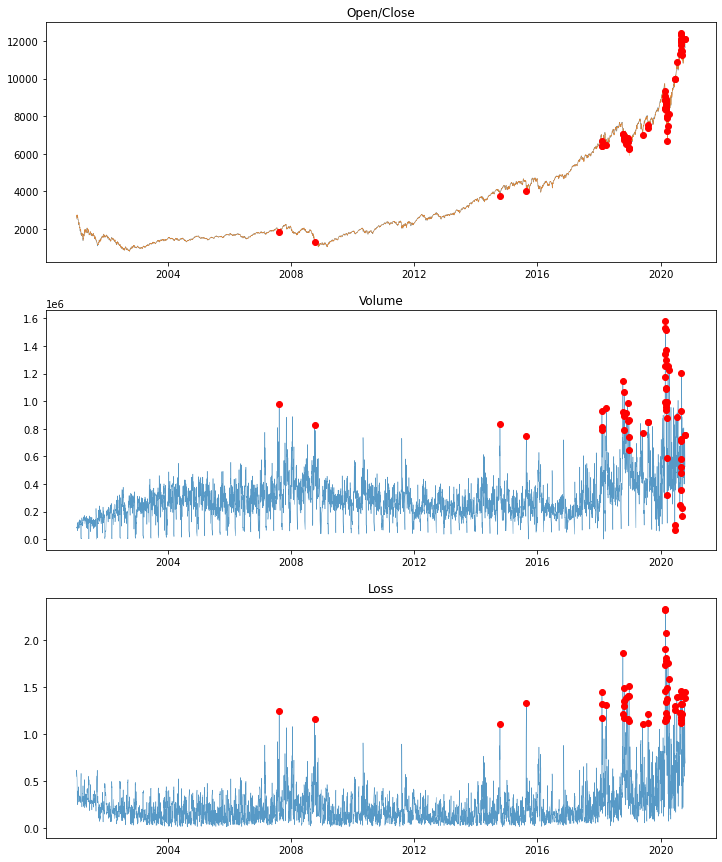

In [69]:
fig = plt.figure(figsize=(12,15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

## Report

4 가지 방법을 이용하여 시계열 데이터에서 outlier를 찾아보았습니다.
- 정규분포의 신뢰구간을 이용  
    
    데이터에서 Open, High, Low, Close 지표에서 대해서 이상치를 확인하였고, 각 지표별로 92, 99, 95, 96개의 이상치를 확인하였습니다.
    
- K-means / DBSCAN
    
    unsupervised clustering으로 K-means 와 DBSCAN를 이용했습니다. 결과를 보면, K-means는 특정 몇개의 그룹만 특이하게 분류하지만, DBSCAN은 2개의 그룹을 제외하고 모두 적은 샘플을 가진 그룹으로 분류합니다.
    
- Auto encoder
    
    thresold를 조절하여 이상치를 확인했는데, 2008년과 2020년에 이상치가 집중되어 나타났습니다.